# Redistribute Dataset split
Currente is bad 33 files inside of validation folder. There are in total 2926 images which needs to be redistributed into a 70:15:15 **random** split. Currently there are 2521 images in the train folder, 33 in the validation folder, and 372 in the test folder.

*Note: the shuffling only happened once. Once code is re-executed, the same images will be present in the corresponding folder!*

In [29]:
import os
import random
import shutil

# Seed for reproducibility
random.seed(42)

# Function to clear the contents of a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Deletes the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreates the directory

# Directories
base_dir = "./Rock-Paper-Scissors"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Temporary directory to consolidate all images
temp_dir = os.path.join(base_dir, "all_images")
clear_directory(temp_dir)

# Target directories for the final split
new_train_dir = os.path.join(base_dir, "resplit_train")
new_val_dir = os.path.join(base_dir, "resplit_validation")
new_test_dir = os.path.join(base_dir, "resplit_test")

# Clear existing directories
clear_directory(new_train_dir)
clear_directory(new_val_dir)
clear_directory(new_test_dir)

# Step 1: Consolidate all images into one folder
def consolidate_images(src_dir, temp_dir, class_name=None):
    for root, _, files in os.walk(src_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(root, file)
                if class_name:  # Add class name as prefix for validation images
                    dst_path = os.path.join(temp_dir, f"{class_name}_{file}")
                else:
                    dst_path = os.path.join(temp_dir, file)
                shutil.copy(src_path, dst_path)

# Consolidate images from train, test, and validation folders
for class_name in ["scissors", "paper", "rock"]:
    consolidate_images(os.path.join(train_dir, class_name), temp_dir, class_name)
    consolidate_images(os.path.join(test_dir, class_name), temp_dir, class_name)
consolidate_images(val_dir, temp_dir)  # Validation images are directly in this folder

# Step 2: Split images into train, validation, and test
all_images = os.listdir(temp_dir)
random.shuffle(all_images)

# Calculate exact split sizes
total_images = len(all_images)
train_size = int(total_images * 0.7)
remaining = total_images - train_size
val_size = remaining // 2
test_size = remaining - val_size

# Check and print sizes
print(f"Training size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Split the images
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

# Step 3: Move images to the new directories
def move_images(image_list, target_dir, no_subfolders=False):
    for img in image_list:
        src_path = os.path.join(temp_dir, img)
        if "_" in img and not no_subfolders:  # For train and test, keep subfolders
            class_name = img.split("_")[0]
            class_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.move(src_path, os.path.join(class_dir, img))
        else:  # For validation, move images directly
            shutil.move(src_path, os.path.join(target_dir, img))

# Move images to their respective folders
move_images(train_images, new_train_dir)
move_images(val_images, new_val_dir, no_subfolders=True)  # No subfolders for validation
move_images(test_images, new_test_dir)

# Remove temporary directory after use
shutil.rmtree(temp_dir)

print("Resplit completed!")


Training size: 2048, Validation size: 439, Test size: 439
Resplit completed!


Validate **new split in resplit_XXX directories**

In [ ]:
def count_images_in_split(target_dir):
    for split in ["resplit_train", "resplit_validation", "resplit_test"]:
        split_dir = os.path.join(base_dir, split)
        total_images = sum([len(files) for _, _, files in os.walk(split_dir)])
        print(f"{split.capitalize()} Set: {total_images} images")

count_images_in_split(base_dir)

# Preprocessing
Fetch data and create test, validation and training datasets

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt


class_names = ["paper", "rock", "scissors"]

def fetch_val_dataset(class_names, val_dir):
    ''' 
    Fetch images from specified dir and process to grayscale and appropriate dims
    '''

    class_to_index = {class_name: i for i, class_name in enumerate(class_names)} # provide index for each label.
    
    # process images and store into array with corresponding labels
    images = []
    labels = []
    
    for file_name in os.listdir(val_dir):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            # extract label from filename.
            label = next((name for name in class_names if name in file_name.lower()), None) 
            if label is not None:
                # Construct the full path to the image
                file_path = os.path.join(val_dir, file_name)
    
                # Process image, i.e. graysale, resize and normalize!!
                with Image.open(file_path).convert("L") as img: #note: L grayscale image
                    img = img.resize((300,300))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
    
            # append label's index.
            labels.append(class_to_index[label])

    # convert ot numpy arrays
    X = np.array(images, dtype="float32") # shape = each sample with 60x60 array
    Y = np.array(labels, dtype="int32") # shape is num of samples, 1

    # add channel dimension to images (for grayscale input)
    X = np.expand_dims(X, axis=-1)

    return X, Y

def visualize_tf_dataset(dataset, class_names, title="Dataset Samples"):
    '''
    Visualize samples of tf_dataset dtype
    '''
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(9):  # Show 9 samples
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")  # Grayscale images
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

def plot_numpy_dataset(X, Y, class_names, title="Validation Dataset Samples"):
    '''
    Visualize samples of Numpy array dtype
    '''
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[i].squeeze(), cmap="gray")
        plt.title(class_names[Y[i]])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



# Set paths for train, validation, and test directories
train_dir = "./Rock-Paper-Scissors/resplit_train"
val_dir = "./Rock-Paper-Scissors/resplit_validation"
test_dir = "./Rock-Paper-Scissors/resplit_test"

# Load datasets
'''
    creates pixels in grayscale 60x60 mode with a 32 batch size. 
    and note: labels => automatically inferred.
'''

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(300, 300),  
    color_mode="grayscale",  
    batch_size=64           
)

X_val, Y_val = fetch_val_dataset(class_names, val_dir)
print(f"Validation images shape: {X_val.shape}")  # Example: (33, 300, 300, 1)
print(f"Validation labels shape: {Y_val.shape}")  # Example: (33,)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(300, 300),
    color_mode="grayscale",  
    batch_size=64
)

# Rescale pixels
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


# Shuffle and prefetch for efficiency
AUTOTUNE = tf.data.AUTOTUNE # prefetching => used to make loading data and preprocessing async to model training
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 2024 files belonging to 3 classes.
Validation images shape: (439, 300, 300, 1)
Validation labels shape: (439,)
Found 432 files belonging to 3 classes.


Visualize samples of each dataset to check correctness of preprocessing


2024-12-11 05:38:20.430112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


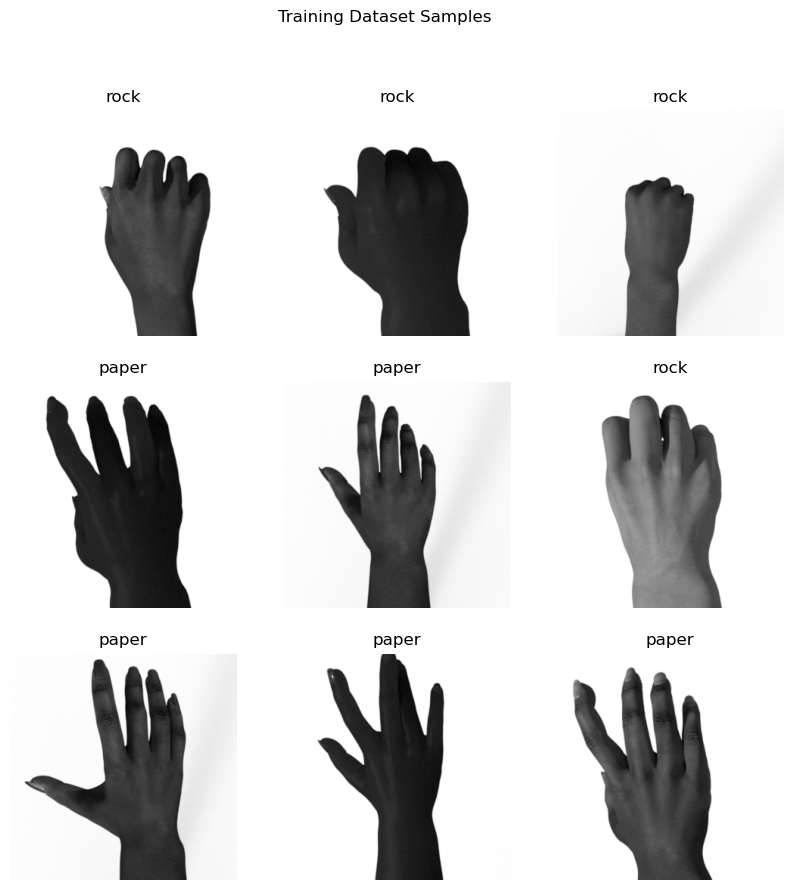

2024-12-11 05:38:21.140497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


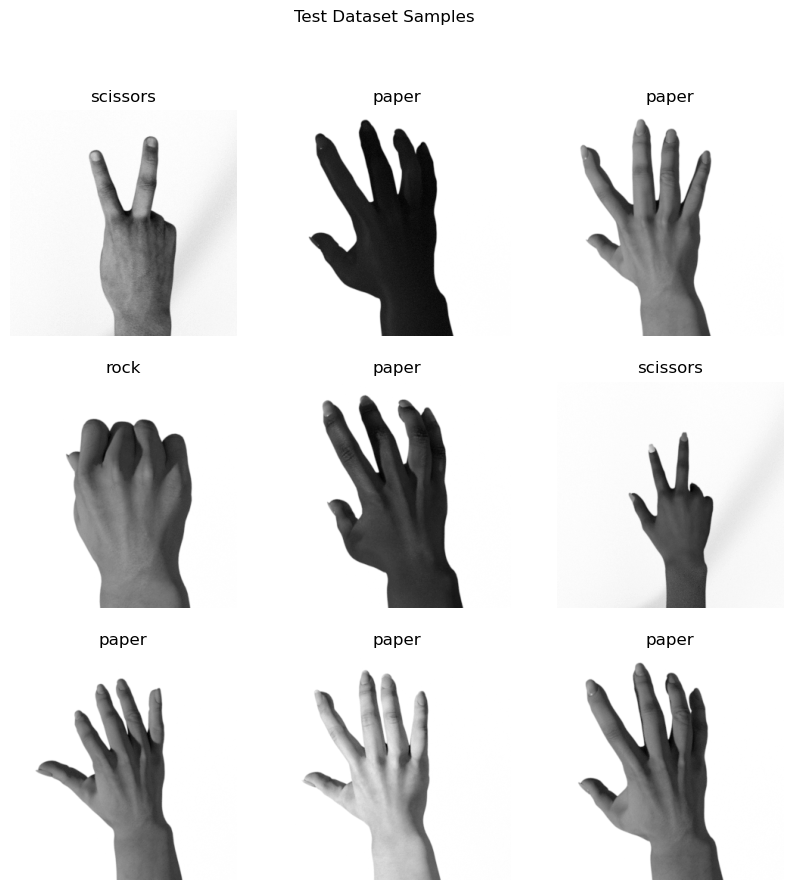

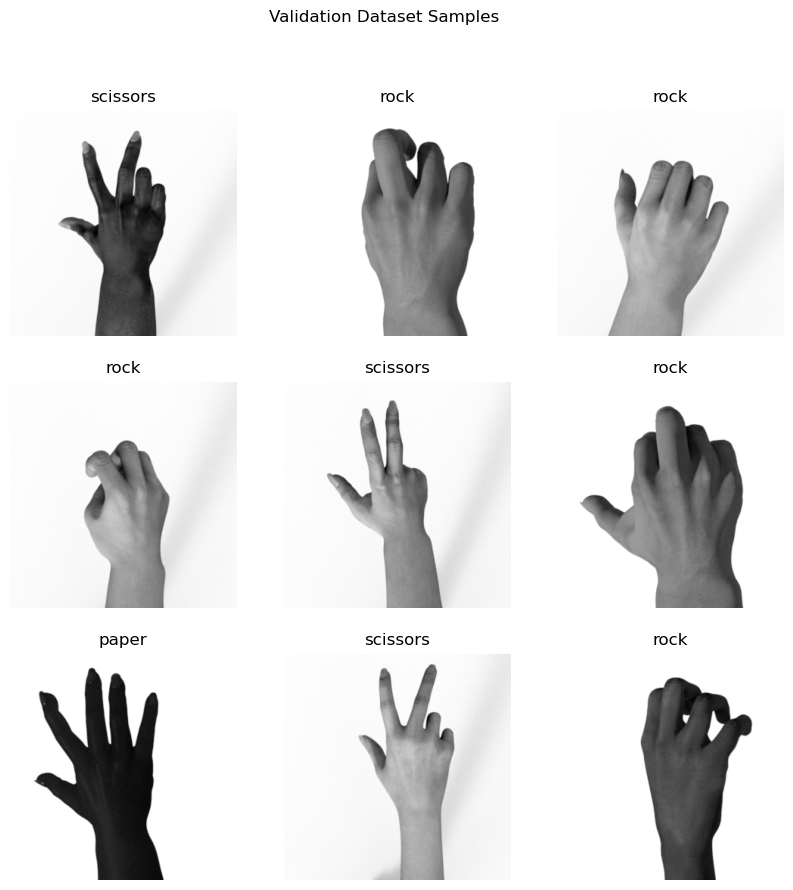

In [4]:
#check whether preprocessing is succesfull by checking a couple of samples
visualize_tf_dataset(train_dataset, class_names, title="Training Dataset Samples")
visualize_tf_dataset(test_dataset, class_names, title="Test Dataset Samples")
plot_numpy_dataset(X_val, Y_val, class_names, title="Validation Dataset Samples")

# 1. NN implementaton 
**manually tuned neurons and layers, regularization and learning rate automatically optimzied (cv_loss VS train_loss compared)**

In this implementation a NN model will be created, fitted and optimized to classify the images



### Model implementation
- [x] Implement manually tuned NN model (went from one layer 256 -> 256,128,64, -> 256,128,128 -> 256, 64, 64 -> 128,64,64) => epoch = 50, learning rate = 0.01, no regularization, no early stopping, no lr_schedule yet, batch size 64, adam optimizer, sparsecategorical loss function)
- [x] tuned further through learning rate optimize to remove spikes from the learning rate due to overshoot and outliers in batches.
- [x] added learning rate schedule to optimize learning rate even further at lower error values where noise became more significant
- [x] configure regularization by testing different values + have a plot
- [ ] todo: configure learning rate and batch size as well + have a plot

note: this is the fully connected NN (FCNN) model which won't be as fast as a CNN model!

In [47]:
model = Sequential([
    layers.Flatten(input_shape=(300, 300, 1)),  # Input layer to flatten the image
    layers.Dense(128, activation='relu', name="L1"),  # Increased neurons
    layers.Dense(64, activation='relu', name="L2"),
    layers.Dense(64, activation='relu', name="L3"),
    layers.Dense(3, activation='softmax', name="output"),  # Output layer for 3 classes
    ],
    name="FCNN_manual"
)

# reducing learning rate => address spike issues in losses
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9
)

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "FCNN_manual"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 90000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1 (Dense)                      │ (None, 128)            │    11,520,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,532,739 (43.99 MB)

 Trainable params: 11,532,739 (43.99 MB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # Use the validation dataset
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9981 - loss: 0.0139 - val_accuracy: 0.9863 - val_loss: 0.0603
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9912 - loss: 0.0286 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9960 - loss: 0.0170 - val_accuracy: 0.9977 - val_loss: 0.0145
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9779 - loss: 0.0610 - val_accuracy: 0.8565 - val_loss: 0.3815
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8872 - loss: 0.3041 - val_accuracy: 0.9886 - val_loss: 0.0471
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9736 - loss: 0.0734 - val_accuracy: 0.9886 - val_loss: 0.0460
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9968 - loss: 0.0225 - val_accuracy: 0.9954 - val_loss: 0.0207
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9980 - loss: 0.0139 - val_accuracy: 0.

### Predict with model and visualize training and validation results

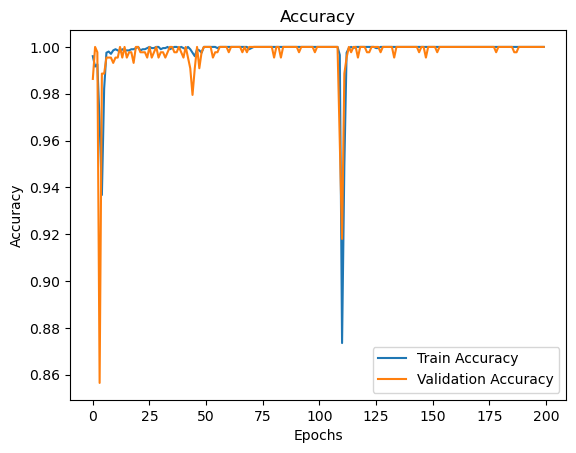

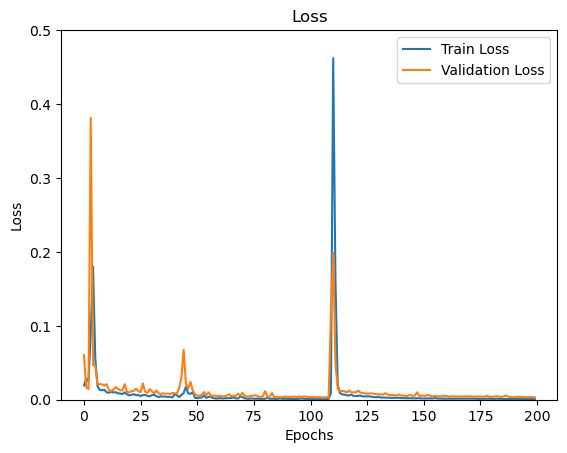

In [35]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.5)  # Replace ymin and ymax with your desired limits
plt.legend()
plt.show()

### Evaluate model with test dataset

In [36]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0016
Test Accuracy: 1.0


In [38]:
# Evaluate one batch of training data
for X_batch, Y_batch in train_dataset.take(1):
    train_loss, train_acc = model.evaluate(X_batch, Y_batch, verbose=0)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

# Evaluate the validation data
val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")



Train Loss: 0.0005232493858784437, Train Accuracy: 1.0


2024-12-10 17:38:36.556322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 0.0030048321932554245, Validation Accuracy: 1.0


### Visualize results
predicatoins vs label for a couple of sapmles

In [39]:
def plot_predictions(model, dataset, class_names, num_samples=9):
    """
    Plot sample images, showing their true labels and predicted labels.
    Args:
        model: Trained model for making predictions.
        dataset: The dataset (tf.data.Dataset or (X, Y) tuple) to draw samples from.
        class_names: List of class names corresponding to labels.
        num_samples: Number of images to display.
    """
    # Prepare the dataset
    if isinstance(dataset, tuple):  # For (X, Y) datasets like validation
        images, labels = dataset
    else:  # For tf.data.Dataset
        images, labels = next(iter(dataset.take(1)))
    
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Plot samples
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(10, 6, i + 1)
        img = images[i].numpy().squeeze()  # Remove batch/channel dimensions if present
        plt.imshow(img, cmap="gray" if img.ndim == 2 else None)  # Handle grayscale or RGB
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


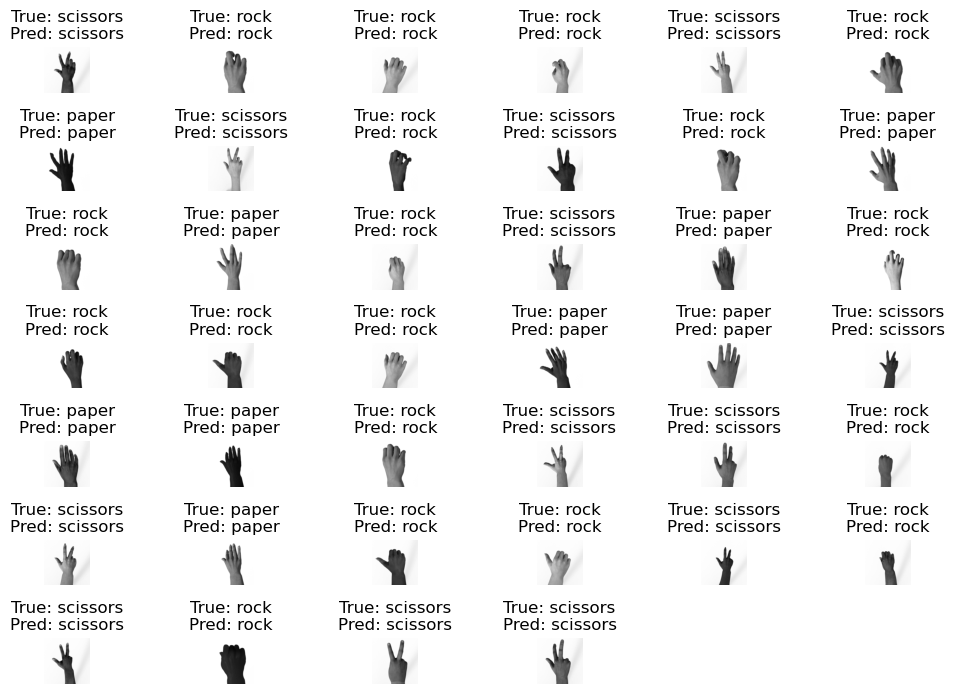

In [40]:
class_names = ["paper", "rock", "scissors"]  # Match your dataset labels

# Plot predictions on validation dataset
plot_predictions(model, val_dataset, class_names, num_samples=40)


## Optimization of hyperparamaters

### Regularization
As a first, lambda will be optimized to determine what the best value for lambda would be for in order to optimize the model even more if possible.

Training model with lambda = 0.0
Finished lambda = 0.0
Training model with lambda = 0.001
Finished lambda = 0.001
Training model with lambda = 0.01
Finished lambda = 0.01
Training model with lambda = 0.05
Finished lambda = 0.05
Training model with lambda = 0.1
Finished lambda = 0.1
Training model with lambda = 0.2
Finished lambda = 0.2
Training model with lambda = 0.3
Finished lambda = 0.3


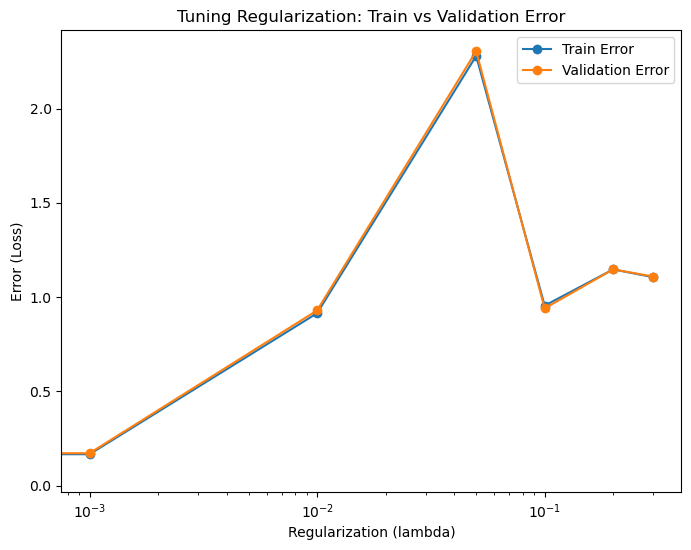

In [67]:
tf.random.set_seed(1234)

# Define regularization strengths
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models = [None] * len(lambdas)

train_errors = []
val_errors = []
val_accuracies = []
train_accuracies = []

# Iterate through each lambda
for i, lambda_ in enumerate(lambdas):
    print(f"Training model with lambda = {lambda_}")
    
    # Define the model
    models[i] = Sequential([
        layers.Flatten(input_shape=(300, 300, 1)),  # Input layer
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
        layers.Dense(3, activation='softmax')  # Output layer
    ])
    
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    # Compile the model
    models[i].compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train the model
    history = models[i].fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=200,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # # Save the final training and validation losses
    # train_errors.append(history.history['loss'][-1])
    # val_errors.append(history.history['val_loss'][-1])

    # Save train and validation losses of the best weights that were chosen (i.e. where the loss was minimal)
    train_loss, train_acc = models[i].evaluate(train_dataset, verbose=0)
    val_loss, val_acc = models[i].evaluate(val_dataset, verbose=0)
    train_errors.append(train_loss)
    val_errors.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Finished lambda = {lambda_}")

# Plot training and validation errors
plt.figure(figsize=(8, 6))
plt.plot(lambdas, train_errors, marker='o', label="Train Error")
plt.plot(lambdas, val_errors, marker='o', label="Validation Error")
plt.xscale('log')
plt.xlabel("Regularization (lambda)")
plt.ylabel("Error (Loss)")
plt.title("Tuning Regularization: Train vs Validation Error")
plt.legend()
plt.show()

In [77]:
min_val = min(val_errors)
max_accuracy = max(val_accuracies)
for i, err in enumerate(val_errors):
    print(f"For lambda = {lambdas[i]} the training error is {train_errors[i]} and the validation error is {err} a validation accuracy of {val_accuracies[i]}")
    if err == min_val:
        print("Where the error is the smallest here.")
    if val_accuracies[i] == max_accuracy:
        print("AND here, the accuracy is the highest.")


For lambda = 0.0 the training error is 0.07638977468013763 and the validation error is 0.09044582396745682 a validation accuracy of 0.9703872203826904
Where the error is the smallest here.
For lambda = 0.001 the training error is 0.16598986089229584 and the validation error is 0.1713765561580658 a validation accuracy of 0.9954441785812378
AND here, the accuracy is the highest.
For lambda = 0.01 the training error is 0.9141218662261963 and the validation error is 0.9288983345031738 a validation accuracy of 0.9293849468231201
For lambda = 0.05 the training error is 2.278827428817749 and the validation error is 2.3044393062591553 a validation accuracy of 0.9043279886245728
For lambda = 0.1 the training error is 0.9543148875236511 and the validation error is 0.9396249055862427 a validation accuracy of 0.8906605839729309
For lambda = 0.2 the training error is 1.1466156244277954 and the validation error is 1.1465400457382202 a validation accuracy of 0.2984054684638977
For lambda = 0.3 the tr

**Conclusion: regularization parameter value of 0 will be best as it has the smallest error**

### Learning rate
Next, the learning rate alpha will be optimized to determine what the best value for alpha would be to optimize the model even more if possible.
note: learning scehduling is removed to tune fixed learning rate.

In [ ]:
tf.random.set_seed(1234)

# Define learning rates
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01]
models = [None] * len(learning_rates)

train_errors = []
val_errors = []
val_accuracies = []
train_accuracies = []

# Iterate through each learning rate
for i, learning_rate in enumerate(learning_rates):
    print(f"Training model with learning rate = {learning_rate}")
    
    # Define the model
    models[i] = Sequential([
        layers.Flatten(input_shape=(300, 300, 1)),  # Input layer
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # Output layer
    ])
    
    # # Learning rate schedule
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     learning_rate=learning_rate,
    #     decay_steps=1000,
    #     decay_rate=0.9
    # )
    
    # Compile the model
    models[i].compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train the model
    history = models[i].fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=200,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Save train and validation losses of the best weights
    train_loss, train_acc = models[i].evaluate(train_dataset, verbose=0)
    val_loss, val_acc = models[i].evaluate(val_dataset, verbose=0)
    train_errors.append(train_loss)
    val_errors.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Finished learning rate = {learning_rate}")

plt.plot(learning_rates, train_errors, marker='o', label="Train Error")
plt.plot(learning_rates, val_errors, marker='o', label="Validation Error")
plt.xscale('log')
plt.xlabel("Learning Rate (alpha))")
plt.ylabel("Error (Loss)")
plt.title("Tuning Learning Rate: Train vs Validation Error")
plt.legend()
plt.show()

[0.09044582396745682, 0.1713765561580658, 0.9288983345031738, 2.3044393062591553, 0.9396249055862427, 1.1465400457382202, 1.1086466312408447]
[0.07638977468013763, 0.16598986089229584, 0.9141218662261963, 2.278827428817749, 0.9543148875236511, 1.1466156244277954, 1.1051712036132812]
[0.0001, 0.0003, 0.001, 0.003, 0.01]
[0.9703872203826904, 0.9954441785812378, 0.9293849468231201, 0.9043279886245728, 0.8906605839729309, 0.2984054684638977, 0.2984054684638977]


ValueError: x and y must have same first dimension, but have shapes (5,) and (7,)

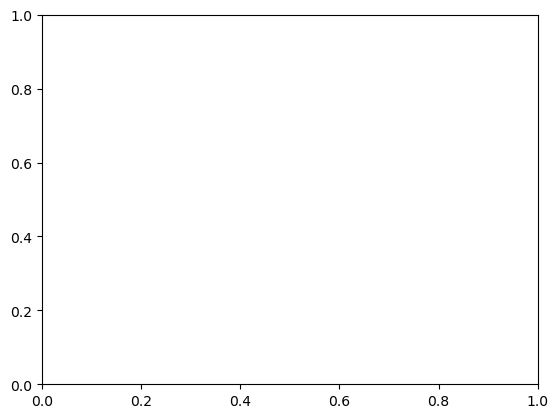

In [68]:
print(val_errors)
print(train_errors)
print(learning_rates)
print(val_accuracies)
# smallest_error = val_errors[0]
# best_learning_rate = learning_rates[0]
# for i, val_error in enumerate(val_errors):
#     if val_error < smallest_error:
#         best_learning_rate = learning_rates[i]

plt.plot(learning_rates, train_errors, marker='o', label="Train Error")
plt.plot(learning_rates, val_errors, marker='o', label="Validation Error")
plt.xscale('log')
plt.xlabel("Learning Rate (alpha))")
plt.ylabel("Error (Loss)")
plt.title("Tuning Learning Rate: Train vs Validation Error")
plt.legend()
plt.show()

Conclusion: use a value of 0.001 for the learning rate as was the case already. 

# 2. NN implementaton with automatic optimization
**automatically tuned neurons and layers, regularization and learning rate automatically optimzied (cv_loss VS train_loss compared)**
note: it is still to be determined where to use grid search to tune multiple hyperparameters at once or do each hyperparameter one by one.

In this implementation another NN model will be created, fitted and optimized to classify the images

## Default model
This is the starting, default model from which the optimization will start. 
TODO LATER, FIRST SIMULATENOUS OPTIMIZATION

## Optimization of layers and neurons
### Individual approach
In this approach the layers and neurons will be optimized separately based on their validation loss to train loss value

### Simulatenous approach
In this approach the layers and neurons will be optimized simulatenously looking at all possible combinations in a layer and neuron range.

#### Create the models

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras import Sequential, layers
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Directory to save models
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Define grid of layers and neurons
layer_options = [1, 2, 3, 4]  # Number of layers
neuron_options = [8,16, 32, 64, 128, 256]  # Number of neurons per layer

# Iterate through each configuration
for num_layers in layer_options:
    for num_neurons in neuron_options:
        print(f"Training model with {num_layers} layers and {num_neurons} neurons per layer")

        # Build the model
        model = Sequential()
        model.add(layers.Flatten(input_shape=(300, 300, 1)))  # Input layer
        for _ in range(num_layers):
            model.add(layers.Dense(num_neurons, activation='relu'))
        model.add(layers.Dense(3))  # Output layer with linear activation (logits)

        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Use logits during training
            metrics=['accuracy']
        )

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )

        # Train the model
        model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=100,
            callbacks=[early_stopping],
            verbose=1
        )

        # Save the model in the native Keras format
        model_name = f"model_{num_layers}L_{num_neurons}N.keras"
        save_model(model, os.path.join(model_dir, model_name))
        print(f"Model saved: {model_name}")

Training model with 1 layers and 8 neurons per layer
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3292 - loss: 16.1394 - val_accuracy: 0.3895 - val_loss: 1.0979
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3265 - loss: 1.0987 - val_accuracy: 0.3895 - val_loss: 1.0981
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3241 - loss: 1.0987 - val_accuracy: 0.3895 - val_loss: 1.0984
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3137 - loss: 1.0987 - val_accuracy: 0.2984 - val_loss: 1.0987
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3488 - loss: 1.0986 - val_accuracy: 0.2984 - val_loss: 1.0990
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3419 - loss: 1.0985 - val_accuracy: 0.2984 - val_loss: 1.0992
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3411 - loss: 1.0985 - val_accuracy: 0.2984 - val_loss: 1.0996
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

#### Load and evaluate models

In [6]:
# Define evaluation function
def eval_cat_err(y_true, y_pred_logits):
    """
    Calculate the categorization error.
    Args:
        y_true : (ndarray or Tensor) True labels.
        y_pred_logits : (ndarray or Tensor) Predicted logits.
    Returns:
        cerr: (scalar) Categorization error (fraction of incorrect predictions).
    """
    y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Apply softmax to logits
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    incorrect = np.sum(y_true != y_pred_classes)
    m = len(y_true)
    cerr = incorrect / m
    return cerr

# Load models and evaluate
results = []
for num_layers in layer_options:
    for num_neurons in neuron_options:
        model_name = f"model_{num_layers}L_{num_neurons}N.keras"
        model_path = os.path.join(model_dir, model_name)

        # Load the model
        model = load_model(model_path)
        print(f"Loaded model: {model_name}")

        # Collect true labels from datasets
        y_train = np.concatenate([y for _, y in train_dataset], axis=0)
        y_val = np.concatenate([y for _, y in val_dataset], axis=0)

        # Predict logits
        train_logits = model.predict(train_dataset)
        val_logits = model.predict(val_dataset)

        # Calculate categorization errors
        train_cerr = eval_cat_err(y_train, train_logits)
        val_cerr = eval_cat_err(y_val, val_logits)

        # Calculate additional metrics
        y_train_pred = np.argmax(tf.nn.softmax(train_logits).numpy(), axis=1)
        y_val_pred = np.argmax(tf.nn.softmax(val_logits).numpy(), axis=1)

        train_precision = precision_score(y_train, y_train_pred, average="weighted")
        train_recall = recall_score(y_train, y_train_pred, average="weighted")
        train_f1 = f1_score(y_train, y_train_pred, average="weighted")

        val_precision = precision_score(y_val, y_val_pred, average="weighted")
        val_recall = recall_score(y_val, y_val_pred, average="weighted")
        val_f1 = f1_score(y_val, y_val_pred, average="weighted")

        # Confusion matrix
        cm_val = confusion_matrix(y_val, y_val_pred)
        cm_train = confusion_matrix(y_train, y_train_pred)

        # Store results
        results.append({
            'num_layers': num_layers,
            'num_neurons': num_neurons,
            'train_cerr': train_cerr,
            'val_cerr': val_cerr,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'cm_train': cm_train,
            'cm_val': cm_val
        })

        print(f"Train Error: {train_cerr:.4f}, Validation Error: {val_cerr:.4f}")
        print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

# Visualize results
for result in results:
    print(result)

Loaded model: model_1L_32N.keras


2024-12-11 05:41:34.992431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:41:35.028756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train Error: 0.6695, Validation Error: 0.6879
Train Precision: 0.1093, Train Recall: 0.3305, Train F1: 0.1642
Val Precision: 0.0974, Val Recall: 0.3121, Val F1: 0.1485


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_1L_64N.keras


2024-12-11 05:41:42.014707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:41:42.041132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train Error: 0.6868, Validation Error: 0.3189
Train Precision: 0.3071, Train Recall: 0.3132, Train F1: 0.2797
Val Precision: 0.7641, Val Recall: 0.6811, Val F1: 0.6341
Loaded model: model_1L_128N.keras


2024-12-11 05:41:49.694230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:41:49.730702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train Error: 0.6625, Validation Error: 0.3645
Train Precision: 0.3306, Train Recall: 0.3375, Train F1: 0.3094
Val Precision: 0.7382, Val Recall: 0.6355, Val F1: 0.6317
Loaded model: model_1L_256N.keras


2024-12-11 05:42:00.796045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:00.821645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train Error: 0.6670, Validation Error: 0.4510
Train Precision: 0.3183, Train Recall: 0.3330, Train F1: 0.2671
Val Precision: 0.7769, Val Recall: 0.5490, Val F1: 0.5331
Loaded model: model_2L_32N.keras


2024-12-11 05:42:08.419412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:08.457282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Error: 0.6586, Validation Error: 0.6515
Train Precision: 0.2165, Train Recall: 0.3414, Train F1: 0.1922
Val Precision: 0.4407, Val Recall: 0.3485, Val F1: 0.2388


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_2L_64N.keras


2024-12-11 05:42:14.672481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:14.712975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train Error: 0.6566, Validation Error: 0.2893
Train Precision: 0.3424, Train Recall: 0.3434, Train F1: 0.3298
Val Precision: 0.7483, Val Recall: 0.7107, Val F1: 0.6907
Loaded model: model_2L_128N.keras


2024-12-11 05:42:23.639467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:23.673155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train Error: 0.6492, Validation Error: 0.4419
Train Precision: 0.3263, Train Recall: 0.3508, Train F1: 0.2858
Val Precision: 0.7605, Val Recall: 0.5581, Val F1: 0.5236
Loaded model: model_2L_256N.keras


2024-12-11 05:42:37.838658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:37.862087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Train Error: 0.6823, Validation Error: 0.3371
Train Precision: 0.3246, Train Recall: 0.3177, Train F1: 0.2789
Val Precision: 0.7830, Val Recall: 0.6629, Val F1: 0.6311
Loaded model: model_3L_32N.keras


2024-12-11 05:42:45.533904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:45.561034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Error: 0.6611, Validation Error: 0.4032
Train Precision: 0.2314, Train Recall: 0.3389, Train F1: 0.2597
Val Precision: 0.4611, Val Recall: 0.5968, Val F1: 0.4964


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_3L_64N.keras


2024-12-11 05:42:53.629012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:42:53.652811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Error: 0.6749, Validation Error: 0.3531
Train Precision: 0.2127, Train Recall: 0.3251, Train F1: 0.2565
Val Precision: 0.4637, Val Recall: 0.6469, Val F1: 0.5374


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_3L_128N.keras


2024-12-11 05:43:03.664929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:43:03.690974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train Error: 0.6724, Validation Error: 0.6036
Train Precision: 0.2513, Train Recall: 0.3276, Train F1: 0.1698
Val Precision: 0.4648, Val Recall: 0.3964, Val F1: 0.2328


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_3L_256N.keras


2024-12-11 05:43:17.410651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:43:17.448968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train Error: 0.6566, Validation Error: 0.6424
Train Precision: 0.2320, Train Recall: 0.3434, Train F1: 0.1936
Val Precision: 0.4842, Val Recall: 0.3576, Val F1: 0.2465


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_4L_32N.keras


2024-12-11 05:43:25.305434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:43:25.342914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Error: 0.6803, Validation Error: 0.2711
Train Precision: 0.3215, Train Recall: 0.3197, Train F1: 0.3102
Val Precision: 0.7268, Val Recall: 0.7289, Val F1: 0.7136
Loaded model: model_4L_64N.keras


2024-12-11 05:43:35.907999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:43:35.937066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Error: 0.6808, Validation Error: 0.5285
Train Precision: 0.2014, Train Recall: 0.3192, Train F1: 0.2065
Val Precision: 0.4022, Val Recall: 0.4715, Val F1: 0.3617


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_4L_128N.keras


2024-12-11 05:43:46.704127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:43:46.756925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train Error: 0.6680, Validation Error: 0.6629
Train Precision: 0.2334, Train Recall: 0.3320, Train F1: 0.1840
Val Precision: 0.3983, Val Recall: 0.3371, Val F1: 0.1976


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loaded model: model_4L_256N.keras


2024-12-11 05:44:02.364611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-11 05:44:02.389822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train Error: 0.6660, Validation Error: 0.6082
Train Precision: 0.3645, Train Recall: 0.3340, Train F1: 0.2164
Val Precision: 0.6626, Val Recall: 0.3918, Val F1: 0.2984
{'num_layers': 1, 'num_neurons': 32, 'train_cerr': 0.6694664031620553, 'val_cerr': 0.6879271070615034, 'train_precision': 0.10925245863862894, 'train_recall': 0.33053359683794464, 'train_f1': 0.16422352490500183, 'val_precision': 0.09738949050700237, 'val_recall': 0.3120728929384966, 'val_f1': 0.1484513414325487, 'cm_train': array([[  0,   0, 657],
       [  0,   0, 698],
       [  0,   0, 669]]), 'cm_val': array([[  0,   0, 171],
       [  0,   0, 131],
       [  0,   0, 137]])}
{'num_layers': 1, 'num_neurons': 64, 'train_cerr': 0.6867588932806324, 'val_cerr': 0.31890660592255127, 'train_precision': 0.3070587964179296, 'train_recall': 0.3132411067193676, 'train_f1': 0.27971207395352454, 'val_precision': 0.764149859648448, 'val_recall': 0.68109

#### Determine best configuration

In [7]:
# Find the best configuration based on the minimum validation error
val_errors = np.array([res['val_cerr'] for res in results]).reshape(len(layer_options), len(neuron_options))
train_errors = np.array([res['train_cerr'] for res in results]).reshape(len(layer_options), len(neuron_options))

min_val_error = np.min(val_errors)
best_config_indices = np.where(val_errors == min_val_error)
best_layer_idx = best_config_indices[0][0]
best_neuron_idx = best_config_indices[1][0]

best_num_layers = layer_options[best_layer_idx]
best_num_neurons = neuron_options[best_neuron_idx]

print(f"Best Configuration:")
print(f" - Number of Layers: {best_num_layers}")
print(f" - Number of Neurons: {best_num_neurons}")
print(f" - Validation Error: {min_val_error:.4f}")
print(f" - Training Error: {train_errors[best_layer_idx, best_neuron_idx]:.4f}")

Best Configuration:
 - Number of Layers: 4
 - Number of Neurons: 32
 - Validation Error: 0.2711
 - Training Error: 0.6803


#### Analysis and visualization of results
Here we have a heatmap in order to visualize the results as the layer and neurons configs are all optimized at once

Metrics that are calculated:
- Categorization Error: Both for training and validation datasets.
- Precision, Recall, and F1-Score: Weighted averages for both training and validation datasets.
- Confusion Matrices: Visualized for training and validation datasets for the best configuration.
- Training and Validation Errors: Plotted using heatmaps and line plots.
- Selection of Best Configuration: Automatically identifies the best layer-neuron combination based on the minimum validation error.
-Epoch-by-Epoch Training Metrics: Stored in the history object for each configuration (useful for future analysis).

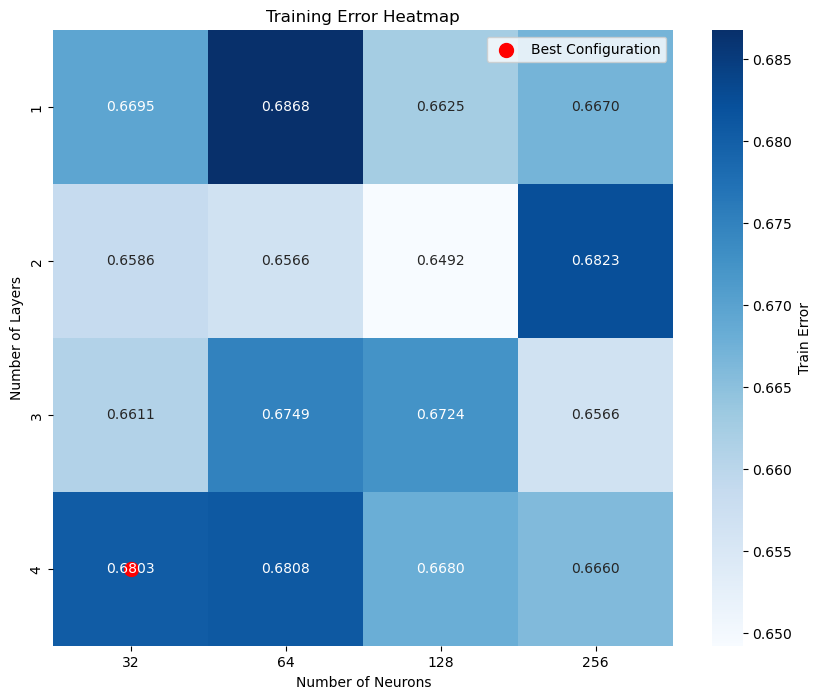

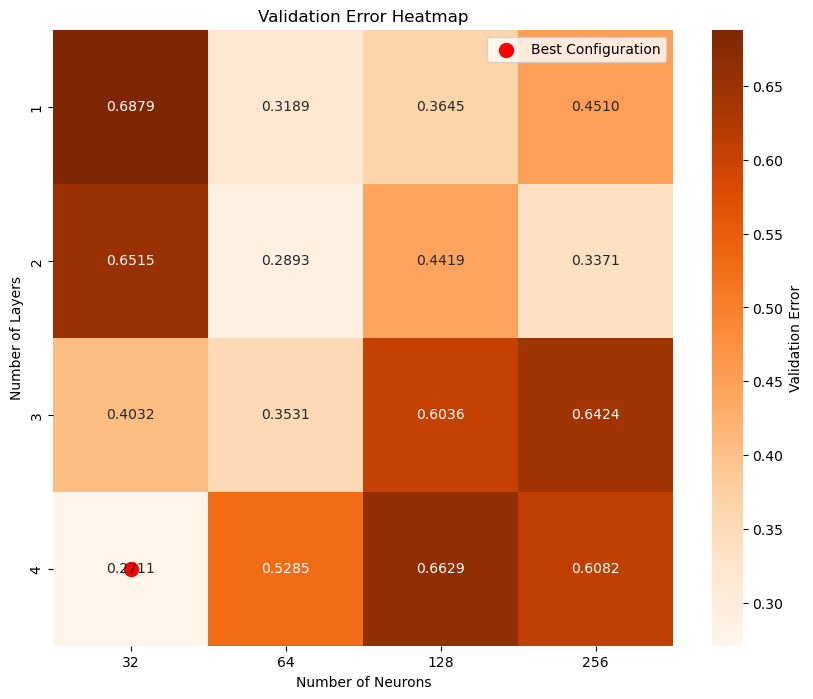

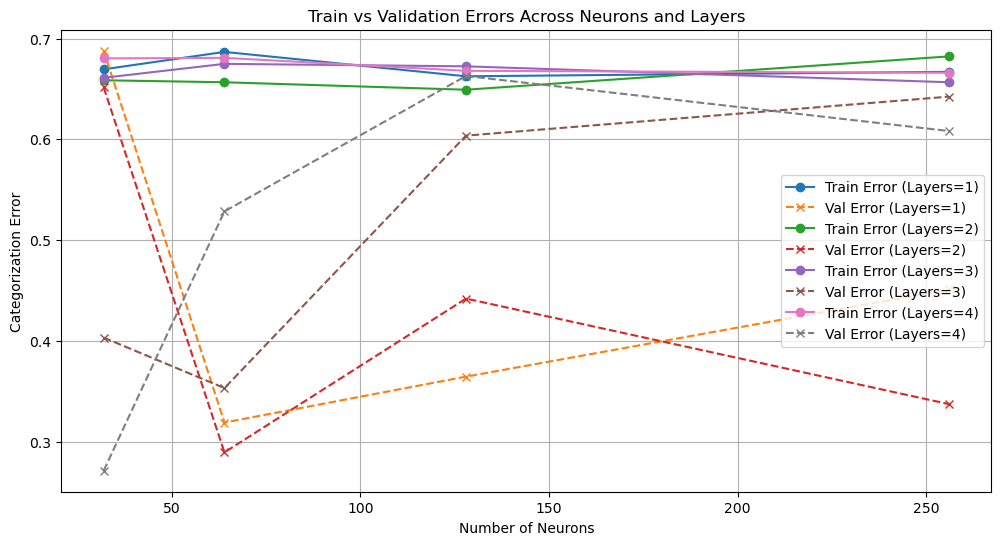

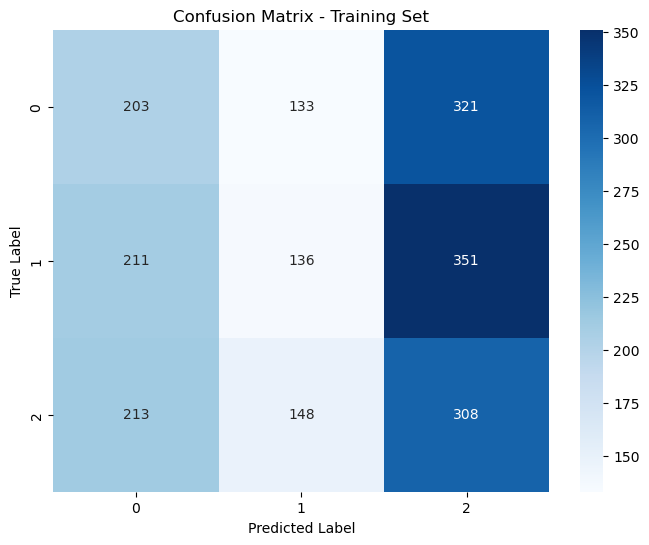

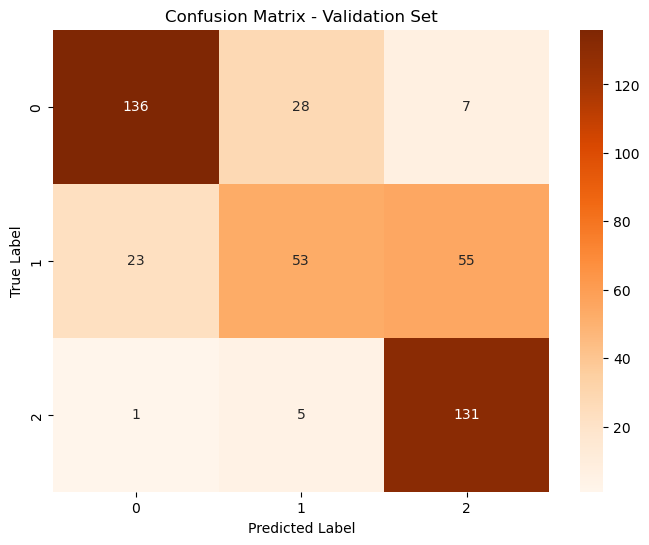

In [8]:
# Heatmap for training error
plt.figure(figsize=(10, 8))
sns.heatmap(
    train_errors,
    annot=True,
    fmt=".4f",
    xticklabels=neuron_options,
    yticklabels=layer_options,
    cmap="Blues",
    cbar_kws={'label': 'Train Error'}
)
plt.title("Training Error Heatmap")
plt.xlabel("Number of Neurons")
plt.ylabel("Number of Layers")
plt.scatter(best_neuron_idx + 0.5, best_layer_idx + 0.5, color='red', s=100, label="Best Configuration")
plt.legend()
plt.show()

# Heatmap for validation error
plt.figure(figsize=(10, 8))
sns.heatmap(
    val_errors,
    annot=True,
    fmt=".4f",
    xticklabels=neuron_options,
    yticklabels=layer_options,
    cmap="Oranges",
    cbar_kws={'label': 'Validation Error'}
)
plt.title("Validation Error Heatmap")
plt.xlabel("Number of Neurons")
plt.ylabel("Number of Layers")
plt.scatter(best_neuron_idx + 0.5, best_layer_idx + 0.5, color='red', s=100, label="Best Configuration")
plt.legend()
plt.show()

# Combined Error Comparison (Optional)
plt.figure(figsize=(12, 6))
for i, layer_count in enumerate(layer_options):
    plt.plot(
        neuron_options,
        train_errors[i, :],
        label=f"Train Error (Layers={layer_count})",
        marker='o'
    )
    plt.plot(
        neuron_options,
        val_errors[i, :],
        label=f"Val Error (Layers={layer_count})",
        linestyle='--',
        marker='x'
    )
plt.title("Train vs Validation Errors Across Neurons and Layers")
plt.xlabel("Number of Neurons")
plt.ylabel("Categorization Error")
plt.legend()
plt.grid()
plt.show()

# Visualize confusion matrix for the best configuration
best_cm_val = results[best_layer_idx * len(neuron_options) + best_neuron_idx]['cm_val']
best_cm_train = results[best_layer_idx * len(neuron_options) + best_neuron_idx]['cm_train']

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_train, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_val, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Camera Predictions

# import cv2

```python
def predict_from_camera(model, class_names):
    """
    Use the camera to capture live frames, preprocess them, and predict using the trained model.
    Args:
        model: Trained model for predictions.
        class_names: List of class names.
    """
    # Open a connection to the webcam
    cap = cv2.VideoCapture(0)  # 0 for the default camera
    
    if not cap.isOpened():
        print("Error: Unable to access the camera.")
        return

    print("Press 'q' to quit the webcam feed.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to capture a frame.")
            break
        
        # Convert the frame to grayscale and resize to the model's input size
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray_frame, (300, 300))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        input_frame = np.expand_dims(normalized_frame, axis=(0, -1))  # Add batch and channel dimensions
        
        # Predict using the model
        predictions = model.predict(input_frame)
        predicted_label = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions)
        
        # Display the prediction on the video feed
        label_text = f"Prediction: {class_names[predicted_label]} ({confidence:.2f})"
        cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Show the video feed
        cv2.imshow("Camera Feed", frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the camera and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Call the function
predict_from_camera(model, class_names)
```

# comparison using minimum loss vs accuracy (categroical error) to evaluate best model!!
### Calculating Errors by Summing All Losses
You're absolutely correct that taking the sum of all losses during training/validation gives a better representation of the overall error than just taking the minimum loss. The rationale is:

Minimum Loss: Reflects only the best point but doesn't account for fluctuations or spikes across epochs.
Summed Loss: Captures the aggregate performance of the model over all epochs, providing a more robust metric for comparison.
By summing losses, you evaluate the total error incurred across the training/validation process, making it a better proxy for overall model performance.

### Why the Previous Comparisons Are Not a Big Problem
Loss and classification error are both valid metrics, and their trends often correlate.
However, classification error (accuracy-based) is more intuitive for tasks like classification, where the primary goal is to minimize misclassifications.